<a href="https://colab.research.google.com/github/vikram409/Tech-Smashers/blob/main/retrain_cifake_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile, os

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/archive22.zip'

os.makedirs('/content/dataset', exist_ok=True)

# Extract the zip file
print(f"Extracting {os.path.basename(zip_path)} ...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Dataset extracted successfully!")

Mounted at /content/drive
Extracting archive.zip ...
Dataset extracted successfully!


In [2]:
!ls "/content/dataset"

test  train


In [3]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'Tesla T4')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import numpy as np


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['FAKE', 'REAL']


In [7]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(512, 1)  # Binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [8]:
num_epochs = 20
train_loss_list = []
train_acc_list = []

for epoch in range(num_epochs):
    model.train()
    total, correct, epoch_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total

    train_loss_list.append(avg_loss)
    train_acc_list.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} Acc: {accuracy:.4f}")


Epoch [1/20] Loss: 0.2407 Acc: 0.9001
Epoch [2/20] Loss: 0.1604 Acc: 0.9379
Epoch [3/20] Loss: 0.1289 Acc: 0.9499
Epoch [4/20] Loss: 0.1060 Acc: 0.9594
Epoch [5/20] Loss: 0.0863 Acc: 0.9678
Epoch [6/20] Loss: 0.0681 Acc: 0.9744
Epoch [7/20] Loss: 0.0525 Acc: 0.9800
Epoch [8/20] Loss: 0.0406 Acc: 0.9848
Epoch [9/20] Loss: 0.0359 Acc: 0.9866
Epoch [10/20] Loss: 0.0275 Acc: 0.9900
Epoch [11/20] Loss: 0.0256 Acc: 0.9911
Epoch [12/20] Loss: 0.0230 Acc: 0.9916
Epoch [13/20] Loss: 0.0206 Acc: 0.9925
Epoch [14/20] Loss: 0.0188 Acc: 0.9934
Epoch [15/20] Loss: 0.0172 Acc: 0.9939
Epoch [16/20] Loss: 0.0162 Acc: 0.9942
Epoch [17/20] Loss: 0.0141 Acc: 0.9951
Epoch [18/20] Loss: 0.0145 Acc: 0.9950
Epoch [19/20] Loss: 0.0127 Acc: 0.9954
Epoch [20/20] Loss: 0.0131 Acc: 0.9955


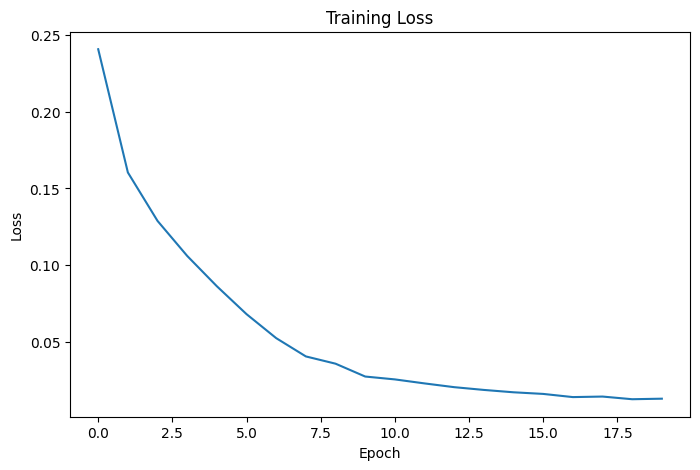

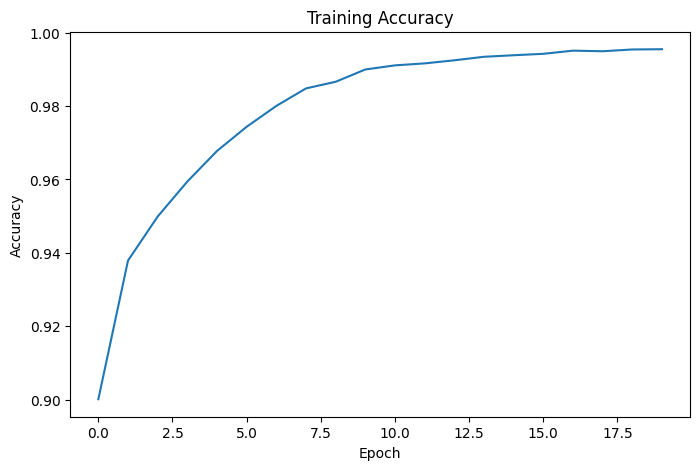

In [9]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_list)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_acc_list)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [10]:
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        scores = torch.sigmoid(outputs).cpu().numpy()
        y_scores.extend(scores.flatten())
        y_true.extend(labels.numpy())

mAP = average_precision_score(y_true, y_scores)
print("Mean Average Precision (mAP):", mAP)


Mean Average Precision (mAP): 0.9932528236387232


In [11]:
save_path = "/content/drive/MyDrive/cifake_deepfake_model.pth"
torch.save(model.state_dict(), save_path)

print("Model saved at:", save_path)


Model saved at: /content/drive/MyDrive/cifake_deepfake_model.pth


In [12]:
import torch
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
from torchvision import models
import torch.nn as nn

model_path = "/content/drive/MyDrive/cifake_deepfake_model.pth"

model = models.resnet18(weights=None)
model.fc = nn.Linear(512, 1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("Model Loaded Successfully!")


Model Loaded Successfully!


In [14]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [15]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        score = torch.sigmoid(output).item()

    prediction = "FAKE" if score > 0.5 else "REAL"
    confidence = score if score > 0.5 else 1 - score

    return prediction, confidence


In [43]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    print("Uploaded file:", img_path)


Saving 0 (2).jpg to 0 (2).jpg
Uploaded file: 0 (2).jpg


In [44]:
prediction, confidence = predict_image(img_path)

print("\nPrediction:", prediction)
print("Confidence:", round(confidence * 100, 2), "%")



Prediction: REAL
Confidence: 100.0 %


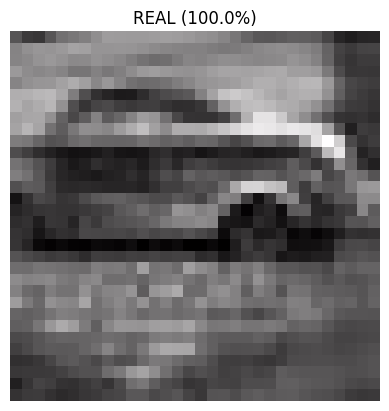

In [45]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"{prediction} ({round(confidence*100,2)}%)")
plt.show()
